<a href="https://colab.research.google.com/github/emiliopugnaloni/Crimenes-Caba/blob/main/3%20-%20Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Libraries**

In [ ]:
!pip install prophet

In [ ]:
# Basics & Pre-Process
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Forecast
from prophet import Prophet
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim



## **Datasets**

In [ ]:
# Import Dataset
df = pd.read_csv('datos_hurto_robo.csv', index_col = 0)

# Change fecha type
df['fecha'] = (pd.to_datetime(df['fecha']))
df['month'] = df['fecha'].dt.month
df['year'] = df['fecha'].dt.year
df['dia'] = df['fecha'].dt.day_name()
df['fecha'] = df['fecha'].dt.date

# Group By
df = df.groupby(['fecha', 'No_Laborable', 'month', 'year', 'dia'])['tipo'].count().reset_index()
df = df.rename(columns = {'tipo':'cant'}).sort_values(by = 'fecha')

df.head(2)

<ipython-input-2-fd06d3c89d4c>:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('datos_hurto_robo.csv', index_col = 0)


,fecha,No_Laborable,month,year,dia,cant
0,2021-01-01,1,1,2021,Friday,138
1,2021-01-02,0,1,2021,Saturday,169


In [ ]:
# Start of the Forecast
FORECAST_START_DATE = max(df['fecha']) - pd.Timedelta(weeks = 5, days = -1)

# Divide by Train and Test
df_train = df[df.fecha < FORECAST_START_DATE]
df_test = df[df.fecha >= FORECAST_START_DATE]
df_test_forecast = df_test[['fecha', 'cant']]
df_test = df_test.drop(columns = ['cant'])

print(f"Train | Days: {df_train.shape[0]} | Min: {df_train['fecha'].min()} | Max: {df_train['fecha'].max()}")
print(f"Test  | Days: {df_test.shape[0]}   | Min: {df_test['fecha'].min()} | Max: {df_test['fecha'].max()}")


Train | Days: 1060 | Min: 2021-01-01 | Max: 2023-11-26
Test  | Days: 35   | Min: 2023-11-27 | Max: 2023-12-31


## **Common Functions**

In [ ]:


def plot_forecast_vs_target(forecast, df, weeks_before_forecast = 10):

  # Get start of train
  train_start_date = max(forecast['fecha']) - pd.Timedelta(days = 1) - pd.Timedelta(weeks = weeks_before_forecast)
  target = df[df.fecha >= train_start_date]

  # Plot
  fig, ax = plt.subplots(figsize = (8,4))
  sns.lineplot(data = target, x = 'fecha', y = 'cant', label = 'Target', color = 'grey')
  sns.lineplot(data = forecast, x = 'fecha', y = 'forecast', label = 'Forecast', color = 'red')
  ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%m'))

  plt.xlabel('Fecha', weight='bold')
  plt.ylabel('Crimenes', weight='bold')
  plt.title('Forecast vs Target', weight='bold')
  plt.show()


def get_metrics(forecast, target):

  tmp = forecast.merge(target, on = 'fecha', how = 'left')
  rmse = np.sqrt(mean_squared_error(tmp['cant'], tmp['forecast']))
  mae = mean_absolute_error(tmp['cant'], tmp['forecast'])

  print(f"RMSE: {round(rmse,1)}")
  print(f"MAE: {round(mae,1)}")

## **Benchmark**

In [ ]:
def forecast_median_days_last_10_weeks(data_train, data_test):

  # Get start and end date of Test
  test_start_date = min(data_test['fecha'])
  test_end_date = max(data_test['fecha'])
  print(f"Test start date: {test_start_date}")
  print(f"Test end date: {test_end_date}")

  # Get start and end date of Train
  train_end_date = test_start_date - pd.Timedelta(days = 1)
  train_start_date = train_end_date - pd.Timedelta(weeks = 10)
  print(f"Train start date: {train_start_date}")
  print(f"Train end date: {train_end_date}\n")

  # Create Train Data
  data_train = data_train[df_train.fecha <= test_start_date]
  data_train = data_train[data_train.fecha >= train_start_date]

  # Forecast
  crimes_by_day = data_train.groupby('dia')['cant'].median().reset_index().rename(columns={'cant':'forecast'})
  data_test = data_test.merge(crimes_by_day, on = 'dia', how = 'left')

  return data_test

In [ ]:
# Get Forecast
benchmark_forecast = forecast_median_days_last_10_weeks(df_train, df_test)

# Get Metrics
get_metrics(benchmark_forecast, df_test_forecast)

Test start date: 2023-11-27
Test end date: 2023-12-31
Train start date: 2023-09-17
Train end date: 2023-11-26

RMSE: 63.0
MAE: 49.4


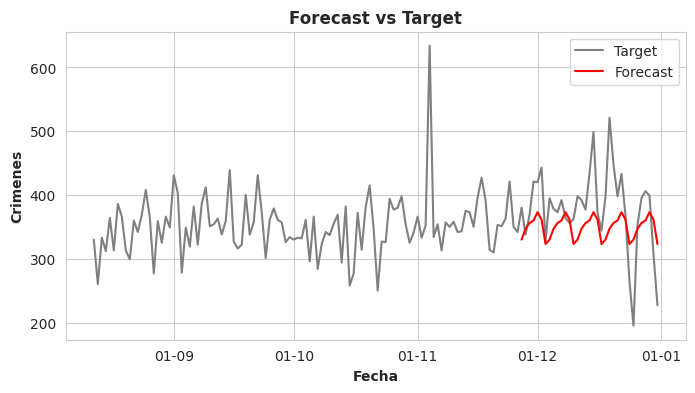

In [ ]:
#Plot
plot_forecast_vs_target(benchmark_forecast, df, weeks_before_forecast = 20)

## **Prohpet**

https://facebook.github.io/prophet/docs/quick_start.html#python-api

In [ ]:
# Dataset
train = df_train.copy()
test = df_test.copy()

train = train.rename(columns={'fecha': 'ds', 'cant': 'y'}) #columns names: "ds" and "y"
test = test.rename(columns={'fecha': 'ds'})

In [ ]:
# Prophet Fit
prophet = Prophet()
prophet.add_regressor('No_Laborable') #si queres agregar otras variables para realizar la predicción
prophet.fit(train)

# Prophet Prediction
predictions = prophet.predict(test)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiyxxn8we/f215p7m1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiyxxn8we/kuyk1idu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27926', 'data', 'file=/tmp/tmpiyxxn8we/f215p7m1.json', 'init=/tmp/tmpiyxxn8we/kuyk1idu.json', 'output', 'file=/tmp/tmpiyxxn8we/prophet_modelj8rhbr_h/prophet_model-20241205205608.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:56:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:56:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Get Metrics
tmp = predictions[['ds', 'yhat']]
tmp = tmp.rename(columns = {'yhat':'forecast', 'ds':'fecha'})
tmp['fecha'] = pd.to_datetime(tmp['fecha']).dt.date

get_metrics(tmp, df_test_forecast)

RMSE: 48.6
MAE: 35.9


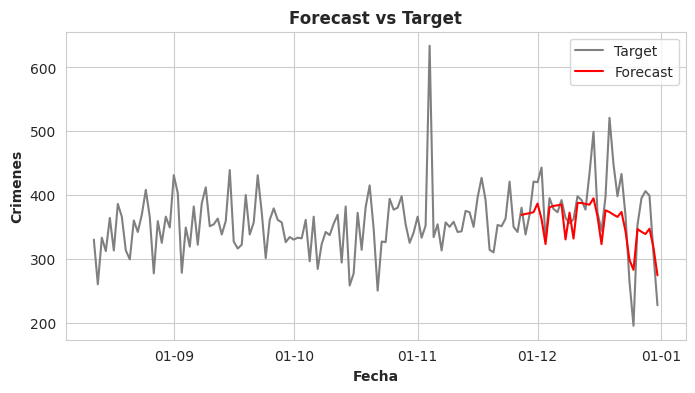

In [ ]:
# Plot
plot_forecast_vs_target(tmp, df, weeks_before_forecast = 20)

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly
plot_components_plotly(prophet, predictions)

/usr/local/lib/python3.10/dist-packages/plotly/io/_json.py:560: UserWarning:

Discarding nonzero nanoseconds in conversion.



## **LSTM 1**

A lstm specialized in predicting the next day crime
When predicting/forecasting in test, we need to add previous prediction to the context window

In [ ]:
print(df_train.shape)
print(df_test.shape)
df_train.head(2)

(1060, 6)
(35, 5)


,fecha,No_Laborable,month,year,dia,cant
0,2021-01-01,1,1,2021,Friday,138
1,2021-01-02,0,1,2021,Saturday,169


#### **Prepare dataset**

In [ ]:
# Set validation Start Date
VALIDATION_SART_DATE = FORECAST_START_DATE - pd.Timedelta(weeks = 5)

data = df.copy()

# Fit scaler on Train Data and apply it to the whole dataset
scaler = MinMaxScaler()
scaler.fit(data[data.fecha < VALIDATION_SART_DATE][['cant']])
data['y'] = scaler.transform(data[['cant']])

# Create Holiday_next_day to be able to predict next day "y"
data['Holiday_next_day'] = data['No_Laborable'].shift(-1).fillna(0).astype(int)

# Create sequences of data-target
def create_sequences(data, window):
    sequences = []
    targets = []
    for i in range(len(data) - window):
        seq = data[i:i + window]
        target = data[i + window][0]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)


WINDOW = 120 # time-window
features = data[['y', 'Holiday_next_day']].values
sequences, targets = create_sequences(features, WINDOW)

print("Full Dataset Dimensions:")
print(sequences.shape) # (data_points, time_steps, feature)
print(targets.shape)

print(targets[len(targets)-1]) # last target
print(sequences[len(sequences)-1][-5:]) # last context to predcit last target
data.tail(5) # last 5 days

Full Dataset Dimensions:
(975, 120, 2)
(975,)
0.23698384201077202
[[0.46319569 0.        ]
 [0.53859964 0.        ]
 [0.55834829 0.        ]
 [0.54578097 0.        ]
 [0.38240575 1.        ]]


,fecha,No_Laborable,month,year,dia,cant,y,Holiday_next_day
1090,2023-12-27,0,12,2023,Wednesday,395,0.538600,0
1091,2023-12-28,0,12,2023,Thursday,406,0.558348,0
1092,2023-12-29,0,12,2023,Friday,399,0.545781,0
1093,2023-12-30,0,12,2023,Saturday,308,0.382406,1
1094,2023-12-31,1,12,2023,Sunday,227,0.236984,0


In [ ]:
# Get the lenght of test
length_test = (data[data.fecha >= FORECAST_START_DATE]).shape[0]
print(length_test) # number of days to forecast in test

# Get start sequence of test
sequences_test_start = sequences[-length_test]
print(sequences_test_start[-5:]) # last 5 days used to start Forecast Prediction

# Get Holiday sequence
sequences_test_holiday = data[-length_test - 1 : -1].Holiday_next_day.values  #need the sequence of holidays starting from the day before

# Get targets of test
targets_test = targets[-length_test:]
print(targets_test[0])  # first target from test

print(FORECAST_START_DATE)
data[data.fecha >= (FORECAST_START_DATE - pd.Timedelta(days = 5))].head(6) #first day to predict

35
[[0.45960503 0.        ]
 [0.48114901 0.        ]
 [0.58527828 0.        ]
 [0.45780969 1.        ]
 [0.44344704 0.        ]]
0.5116696588868941
2023-11-27


,fecha,No_Laborable,month,year,dia,cant,y,Holiday_next_day
1055,2023-11-22,0,11,2023,Wednesday,351,0.459605,0
1056,2023-11-23,0,11,2023,Thursday,363,0.481149,0
1057,2023-11-24,0,11,2023,Friday,421,0.585278,0
1058,2023-11-25,0,11,2023,Saturday,350,0.457810,1
1059,2023-11-26,1,11,2023,Sunday,342,0.443447,0
1060,2023-11-27,0,11,2023,Monday,380,0.511670,0


In [ ]:
# Get the lenght of val
length_val = (data[(data.fecha >= VALIDATION_SART_DATE) & (data.fecha < FORECAST_START_DATE)]).shape[0]
print(length_val) # number of days to forecast in test

# Get start sequence of tvalest
sequences_val_start = sequences[-length_test-length_val]
print(sequences_val_start[-5:]) # last 5 days used to start Forecast Prediction

# Get Holiday sequence
sequences_val_holiday = data[-length_test-length_val -1 :-length_test-1].Holiday_next_day.values # we get the holidays column

# Get targets of val
targets_val = targets[-length_test-length_val:-length_test]
print(targets_val[0])  # first target from val

print(VALIDATION_SART_DATE)
data[data.fecha >= (VALIDATION_SART_DATE - pd.Timedelta(days = 5))].head(6) #first day to predict

35
[[0.39317774 0.        ]
 [0.51346499 0.        ]
 [0.57450628 0.        ]
 [0.4524237  1.        ]
 [0.27827648 0.        ]]
0.4165170556552963
2023-10-23


,fecha,No_Laborable,month,year,dia,cant,y,Holiday_next_day
1020,2023-10-18,0,10,2023,Wednesday,314,0.393178,0
1021,2023-10-19,0,10,2023,Thursday,381,0.513465,0
1022,2023-10-20,0,10,2023,Friday,415,0.574506,0
1023,2023-10-21,0,10,2023,Saturday,347,0.452424,1
1024,2023-10-22,1,10,2023,Sunday,250,0.278276,0
1025,2023-10-23,0,10,2023,Monday,327,0.416517,0


In [ ]:
# Get the train sequences
sequences_train = sequences[:-length_test-length_val]
targets_train = targets[:-length_test-length_val]

print("\nTrain Dataset Dimensions:")
print(sequences_train.shape)
print(targets_train.shape)


Train Dataset Dimensions:
(905, 120, 2)
(905,)


In [ ]:
# Convert sequences to tensors
sequences_train = torch.tensor(sequences_train, dtype=torch.float32)
print(sequences_train.shape)
targets_train = torch.tensor(targets_train, dtype=torch.float32).unsqueeze(1) # we add a dimension
print(targets_train.shape)

sequences_val_start = torch.tensor(sequences_val_start, dtype=torch.float32)
print(sequences_val_start.shape)

sequences_test_start = torch.tensor(sequences_test_start, dtype=torch.float32)
print(sequences_val_start.shape)



torch.Size([905, 120, 2])
torch.Size([905, 1])
torch.Size([120, 2])
torch.Size([120, 2])


In [ ]:
# TimeSeriesDataset (which subclasses torch.utils.data.Dataset) is to organize the
# data and make it easier to work with during training. This class serves as a bridge between
# your data (sequences and targets) and PyTorch's DataLoader, which handles batching and shuffling automatically

class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]


In [ ]:
# After creating a custom Dataset class, we can pass it to a DataLoader, which automatically
# handles batching and other functionality.

batch_size = 32
train_dataset = TimeSeriesDataset(sequences_train, targets_train) # we create the Pytorch Dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # we organize it in Batches and we shuffle them


#### **Training**

In [ ]:
class LSTMTimeSeries(nn.Module):
    def __init__(self, input_size = 2, hidden_size = 20, output_size = 1):
        super(LSTMTimeSeries, self).__init__()
        self.lstm_1 = nn.LSTM(input_size, hidden_size, batch_first=True, dropout = 0.0) # receive: (batch_size, seq_length, input_size)
        self.lstm_2 = nn.LSTM(hidden_size, hidden_size, batch_first=True, dropout=0.0) #receive: (batch_size, seq_length, hidden_size)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, output_size) #receive: (batch_size, 1 , hidden_size)

    def forward(self, x):
        x, _ = self.lstm_1(x)  # LSTM 1 output
        #x, _ = self.lstm_2(x) # LSTM 2 output
        x = self.dropout(x)
        last_time_step = x[:, -1, :]  # Extract the last time step
        out = self.fc(last_time_step)  # Fully connected layer
        return out


In [ ]:
def train(model, num_epochs, train_loader, criterion, optimizer):

  # Set model in trainning mode
  model.train()

  # Iterate through epochs
  for epoch in range(num_epochs):
      epoch_loss = 0

      # Iterate through bathces
      for batch_idx, (seqs, target) in enumerate(train_loader):

          # Zero the gradients
          optimizer.zero_grad()

          # Forward pass
          output = model(seqs)

          # Calculate the loss
          loss = loss_function(output, target)

          # Backpropagate
          loss.backward()

          # Update the weights
          optimizer.step()

          # Track the loss
          epoch_loss += loss.item()

      # Print the average loss for this epoch
      if (epoch + 1) % 2 == 0:
          rmse, mae, target_unscaled, predictions_unscaled, _ = lstm_test_forecast_1(model, sequences_val_start, targets_val, sequences_val_holiday, scaler)

          print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {round(epoch_loss / len(train_loader),5)}, RMSE: {rmse}, MAE: {mae}")


In [ ]:
def lstm_test_forecast_1(model, sequences_start, targets, sequences_holiday, scaler):

  model.eval()
  predictions = []

  pred_sequences = sequences_start.clone()
  target_sequences = targets.copy()
  holidays_sequences = sequences_holiday.copy()

  for i in range(target_sequences.shape[0]):
      with torch.no_grad():
          #print(f"{i} .Target: {target_sequences[i]}. Holiday: {holidays_sequences[i]}")

          if i!=0:
            # Add new row, based on (last_prediction, holiday)
            new_row = torch.tensor([pred.item(), holidays_sequences[i]])
            pred_sequences = torch.cat((pred_sequences[1:], new_row.unsqueeze(0)), dim=0)

          # Make the prediction
          pred = model(pred_sequences.unsqueeze(0))

          # Save the prediction
          predictions.append(pred.item())


  # Calculate Metrics With Unscaled Values
  target_unscaled = scaler.inverse_transform(target_sequences.reshape(-1,1))
  predictions_unscaled = scaler.inverse_transform(np.array(predictions).reshape(-1,1))

  rmse = np.sqrt(mean_squared_error(target_unscaled, predictions_unscaled))
  mae = mean_absolute_error(target_unscaled.tolist(), predictions_unscaled)

  return round(rmse,1), round(mae,1), target_unscaled, predictions_unscaled, pred_sequences


In [ ]:
# Instantiate  Model, Loss and Optimizer
torch.manual_seed(123)
model = LSTMTimeSeries(input_size=2, hidden_size=40, output_size=1)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of Epochs
num_epochs = 20

train(model, num_epochs, train_loader, loss_function, optimizer)

Epoch [2/20], Loss: 0.01589, RMSE: 98.6, MAE: 81.1
Epoch [4/20], Loss: 0.01162, RMSE: 84.0, MAE: 64.8
Epoch [6/20], Loss: 0.0072, RMSE: 206.9, MAE: 198.0
Epoch [8/20], Loss: 0.00588, RMSE: 75.7, MAE: 55.4
Epoch [10/20], Loss: 0.00413, RMSE: 102.7, MAE: 85.7
Epoch [12/20], Loss: 0.00437, RMSE: 53.6, MAE: 29.7
Epoch [14/20], Loss: 0.00381, RMSE: 52.4, MAE: 29.6
Epoch [16/20], Loss: 0.00377, RMSE: 52.6, MAE: 30.4
Epoch [18/20], Loss: 0.00352, RMSE: 58.7, MAE: 34.4
Epoch [20/20], Loss: 0.00353, RMSE: 55.0, MAE: 31.2


### **Test**

In [ ]:
## TEST
rmse, mae, target_unscaled, predictions_unscaled, pred_sequence = lstm_test_forecast_1(model, sequences_test_start, targets_test, sequences_test_holiday, scaler)
print(f"RMSE: {rmse}, MAE: {mae}")

RMSE: 52.9, MAE: 37.1


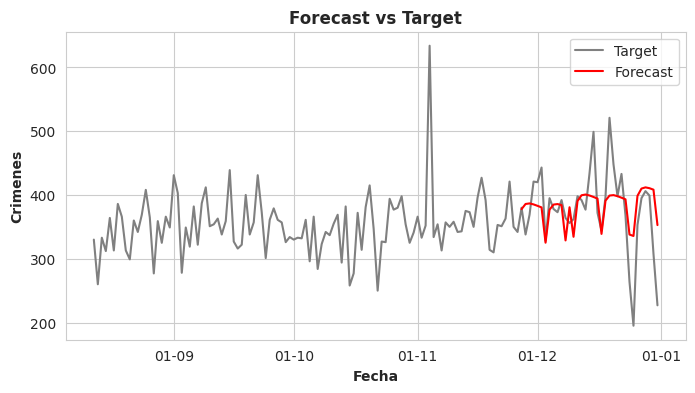

In [ ]:
forecast_lstm1 = df_test.copy()
forecast_lstm1['forecast'] = predictions_unscaled

plot_forecast_vs_target(forecast_lstm1, df, weeks_before_forecast = 20)


## **LSTM 2**

Predict each day crime of a 7 weeks target

### **Prepare Dataset**

In [ ]:
# Set validation Start Date
VALIDATION_SART_DATE = FORECAST_START_DATE - pd.Timedelta(weeks = 5)

data = df.copy()

# Fit scaler on Train Data and apply it to the whole dataset
scaler = MinMaxScaler()
scaler.fit(data[data.fecha < VALIDATION_SART_DATE][['cant']])
data['y'] = scaler.transform(data[['cant']])

# Create Holiday_next_day to be able to predict next day "y"
data['Holiday_next_day'] = data['No_Laborable'].shift(-36).fillna(0).astype(int)

# Create sequences of data-target
def create_sequences(data, window, n_target):
    sequences = []
    targets = []
    for i in range(len(data) - window - n_target + 1):
        seq = data[i:i + window]
        target = data[i + window: i + window + n_target][:,0]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)


WINDOW = 120 # time-window
N_TARGET = len(df_test)
features = data[['y', 'Holiday_next_day']].values
sequences, targets = create_sequences(features, WINDOW, N_TARGET)

print("Full Dataset Dimensions:")
print(sequences.shape) # (data_points, time_steps, feature)
print(targets.shape)

data.tail(5) # last 5 days

Full Dataset Dimensions:
(941, 120, 2)
(941, 35)


,fecha,No_Laborable,month,year,dia,cant,y,Holiday_next_day
1090,2023-12-27,0,12,2023,Wednesday,395,0.538600,0
1091,2023-12-28,0,12,2023,Thursday,406,0.558348,0
1092,2023-12-29,0,12,2023,Friday,399,0.545781,0
1093,2023-12-30,0,12,2023,Saturday,308,0.382406,0
1094,2023-12-31,1,12,2023,Sunday,227,0.236984,0


In [ ]:
# Get the lenght of test
length_test = (data[data.fecha >= FORECAST_START_DATE]).shape[0]
print(length_test) # number of days to forecast in test

# Get sequence of test
sequence_test = sequences[-1] # is the last sequences (as the sequence have length = length_test)
targets_test = targets[-1]

print(FORECAST_START_DATE)
print(targets_test[-1])
data.iloc[-5:]


35
2023-11-27
0.23698384201077202


,fecha,No_Laborable,month,year,dia,cant,y,Holiday_next_day
1090,2023-12-27,0,12,2023,Wednesday,395,0.538600,0
1091,2023-12-28,0,12,2023,Thursday,406,0.558348,0
1092,2023-12-29,0,12,2023,Friday,399,0.545781,0
1093,2023-12-30,0,12,2023,Saturday,308,0.382406,0
1094,2023-12-31,1,12,2023,Sunday,227,0.236984,0


In [ ]:
# Get the lenght of test
length_val = (data[(data.fecha >= VALIDATION_SART_DATE) & (data.fecha < FORECAST_START_DATE)]).shape[0]
print(length_val) # number of days to forecast in test

# Get sequence of val
sequence_val = sequences[-length_val-1] # is the last sequence (the one assigned to df_test) - length df_val
targets_val = targets[-length_val-1]

print(VALIDATION_SART_DATE)
print(FORECAST_START_DATE)
print(targets_val[-1])
data.loc[data.fecha <= FORECAST_START_DATE].tail(10)

35
2023-10-23
2023-11-27
0.4434470377019749


,fecha,No_Laborable,month,year,dia,cant,y,Holiday_next_day
1051,2023-11-18,0,11,2023,Saturday,392,0.533214,1
1052,2023-11-19,1,11,2023,Sunday,314,0.393178,1
1053,2023-11-20,1,11,2023,Monday,310,0.385996,0
1054,2023-11-21,0,11,2023,Tuesday,353,0.463196,0
1055,2023-11-22,0,11,2023,Wednesday,351,0.459605,0
1056,2023-11-23,0,11,2023,Thursday,363,0.481149,0
1057,2023-11-24,0,11,2023,Friday,421,0.585278,0
1058,2023-11-25,0,11,2023,Saturday,350,0.457810,1
1059,2023-11-26,1,11,2023,Sunday,342,0.443447,0
1060,2023-11-27,0,11,2023,Monday,380,0.511670,0


In [ ]:
# Get the train sequences
sequences_train = sequences[:-length_val-1]
targets_train = targets[:-length_val-1]

print("\nTrain Dataset Dimensions:")
print(sequences_train.shape)
print(targets_train.shape)


Train Dataset Dimensions:
(905, 120, 2)
(905, 35)


In [ ]:
# Convert sequences to tensors
sequences_train = torch.tensor(sequences_train, dtype=torch.float32)
print(sequences_train.shape)
targets_train = torch.tensor(targets_train, dtype=torch.float32).unsqueeze(2) # we add a dimension
print(targets_train.shape)

sequence_val = torch.tensor(sequence_val, dtype=torch.float32)
print(sequence_val.shape)

sequence_test = torch.tensor(sequence_test, dtype=torch.float32)
print(sequence_test.shape)



torch.Size([905, 120, 2])
torch.Size([905, 35, 1])
torch.Size([120, 2])
torch.Size([120, 2])


In [ ]:
# After creating a custom Dataset class, we can pass it to a DataLoader, which automatically
# handles batching and other functionality.

batch_size = 32
train_dataset = TimeSeriesDataset(sequences_train, targets_train) # we create the Pytorch Dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # we organize it in Batches and we shuffle them


### **Training**

In [ ]:
class LSTMTimeSeries(nn.Module):
    def __init__(self, input_size = 2, hidden_size = 100, output_size = 35):
        super(LSTMTimeSeries, self).__init__()
        self.lstm_1 = nn.LSTM(input_size, hidden_size, batch_first=True, dropout = 0.0) # receive: (batch_size, seq_length, input_size)
        self.lstm_2 = nn.LSTM(hidden_size, hidden_size, batch_first=True, dropout=0.0) #receive: (batch_size, seq_length, hidden_size)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, output_size) #receive: (batch_size, 35 , hidden_size)

    def forward(self, x):
        x, _ = self.lstm_1(x)  # LSTM 1 output
        #x, _ = self.lstm_2(x) # LSTM 2 output
        x = self.dropout(x)
        last_time_step = x[:, -1, :]  # Extract the last time step
        out = self.fc(last_time_step)  # Fully connected layer
        return out


In [ ]:
def train(model, num_epochs, train_loader, criterion, optimizer):

  # Set model in trainning mode
  model.train()

  # Iterate through epochs
  for epoch in range(num_epochs):
      epoch_loss = 0

      # Iterate through bathces
      for batch_idx, (seqs, target) in enumerate(train_loader):

          model.train()

          # Zero the gradients
          optimizer.zero_grad()

          # Forward pass
          output = model(seqs)

          # Calculate the loss
          loss = loss_function(output.unsqueeze(-1), target)

          # Backpropagate
          loss.backward()

          # Update the weights
          optimizer.step()

          # Track the loss
          epoch_loss += loss.item()

      # Print the average loss for this epoch
      if (epoch + 1) % 2 == 0:
          rmse, mae, target_unscaled, predictions_unscaled, predictions = lstm_test_forecast_2(model, sequence_val, targets_val, scaler)

          print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {round(epoch_loss / len(train_loader),5)}, RMSE: {rmse}, MAE: {mae}")


In [ ]:
def lstm_test_forecast_2(model, sequence, targets, scaler):

  model.eval()

  pred = model(sequence.unsqueeze(0))
  predictions = pred.detach().numpy()

  # Calculate Metrics With Unscaled Values
  target_unscaled = scaler.inverse_transform(targets.reshape(-1,1))
  predictions_unscaled = scaler.inverse_transform(predictions.reshape(-1,1))

  rmse = np.sqrt(mean_squared_error(target_unscaled, predictions_unscaled))
  mae = mean_absolute_error(target_unscaled.tolist(), predictions_unscaled)

  return round(rmse,1), round(mae,1), target_unscaled, predictions_unscaled, predictions

In [ ]:
# Instantiate  Model, Loss and Optimizer
torch.manual_seed(123)
model_2 = LSTMTimeSeries(input_size=2, hidden_size=100, output_size=35)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.01)

# Number of Epochs
num_epochs = 30

train(model_2, num_epochs, train_loader, loss_function, optimizer)

Epoch [2/30], Loss: 0.01237, RMSE: 74.1, MAE: 51.7
Epoch [4/30], Loss: 0.00733, RMSE: 61.7, MAE: 34.9
Epoch [6/30], Loss: 0.00661, RMSE: 64.2, MAE: 38.9
Epoch [8/30], Loss: 0.00649, RMSE: 58.0, MAE: 30.5
Epoch [10/30], Loss: 0.00603, RMSE: 62.1, MAE: 35.2
Epoch [12/30], Loss: 0.00599, RMSE: 64.6, MAE: 38.6
Epoch [14/30], Loss: 0.00654, RMSE: 62.9, MAE: 34.7
Epoch [16/30], Loss: 0.00554, RMSE: 60.9, MAE: 32.7
Epoch [18/30], Loss: 0.00532, RMSE: 61.3, MAE: 33.9
Epoch [20/30], Loss: 0.00525, RMSE: 63.4, MAE: 36.7
Epoch [22/30], Loss: 0.00503, RMSE: 59.1, MAE: 32.5
Epoch [24/30], Loss: 0.00496, RMSE: 56.4, MAE: 30.1
Epoch [26/30], Loss: 0.00499, RMSE: 52.3, MAE: 28.1
Epoch [28/30], Loss: 0.00494, RMSE: 57.7, MAE: 32.4
Epoch [30/30], Loss: 0.00479, RMSE: 59.2, MAE: 31.2


### **Testing**

In [ ]:
## TEST
rmse, mae, target_unscaled, predictions_unscaled, predictions = lstm_test_forecast_2(model_2, sequence_test, targets_test, scaler)
print(f"RMSE: {rmse}, MAE: {mae}")

RMSE: 61.1, MAE: 46.8


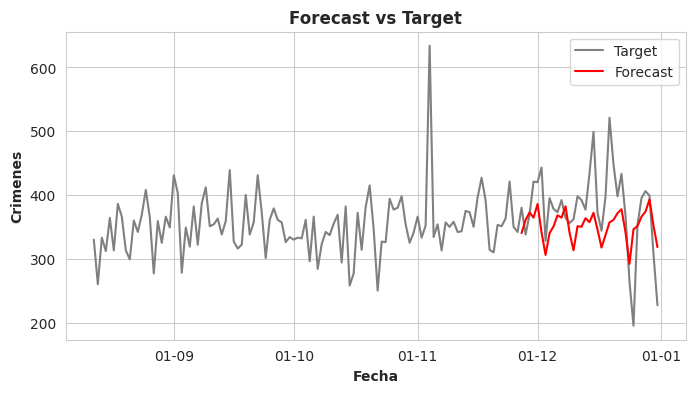

In [ ]:
forecast_lstm2 = df_test.copy()
forecast_lstm2['forecast'] = predictions_unscaled

plot_forecast_vs_target(forecast_lstm2, df, weeks_before_forecast=20)
